In [58]:
import gensim
import nltk
import multiprocessing
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

In [6]:
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

In [7]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [96]:
df = pd.read_csv('clean_tweets_update.csv', usecols=['clean_keyword', 'clean_location', 'clean_tweets', 'tweets', 'pos_lems'])

In [97]:
target_df = pd.read_csv('train.csv', usecols=['target'])
target = list(target_df.target)

In [98]:
print(len(target))

7613


In [99]:
train_df, test_df = df.iloc[:len(target_df), :], df.iloc[len(target_df):, :] 
train_df['target'] = target
train_df.drop_duplicates(subset=['pos_lems'], keep='last', inplace=True)

In [100]:
len(train_df)

6851

In [101]:
len(test_df)

3263

In [102]:
tweets = list(train_df.clean_tweets)
for x in test_df.clean_tweets:
    tweets.append(x) 
len(tweets)

10114

In [103]:
def kw_loc_column_fix(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'\bnan\b', r'')
    df['clean_keyword'] = df.clean_keyword.str.replace(r' ', r'_')
    df['clean_keyword'] = df.clean_keyword.str.strip()
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.strip()
    df['clean_location'] = df.clean_location.str.replace(r'\bnan\b', r'')
    df['clean_location'] = df.clean_location.str.replace(r' ', r'_')
    return df

In [104]:
df = kw_loc_column_fix(df)

In [105]:
train_df = kw_loc_column_fix(train_df)
test_df = kw_loc_column_fix(test_df)

In [106]:
keyword = pd.get_dummies(train_df.clean_keyword, prefix='keyword')
location = pd.get_dummies(train_df.clean_location, prefix='location')
train_df_secondary = pd.concat([keyword, location], axis=1)

keyword_test = pd.get_dummies(test_df.clean_keyword, prefix='keyword')
location_test = pd.get_dummies(test_df.clean_location, prefix='location')
test_df_secondary = pd.concat([keyword_test, location_test], axis=1)

In [218]:
df['texts'] = df.tweets.apply(tokenize_text)

In [171]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word)>1:
                tokens.append(word.lower())
    return tokens

In [ ]:
from collections import Counter
from statistics import mean

In [220]:
word_dict = Counter(df.texts.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
print(f'There are {vocab_size} unique words in the training dataset')
print("max len of tweets",max([len(x) for x in df.texts]))
print("min len of tweets",min([len(x) for x in df.texts]))
print("mean len of tweets", mean([len(x) for x in df.texts]))

There are 124880 words in the training dataset
There are 13307 unique words in the training dataset
max len of tweets 28
min len of tweets 1
mean len of tweets 11.48216255976462


## wordcloud

In [107]:
from wordcloud import WordCloud
def plot_wordcloud (df): 
    pos_ = df[df['target']==1]['tweets']
    neg_ = df[df['target']==0]['tweets']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
    wordcloud1 = WordCloud( background_color='black',
                          width=600,
                          height=400).generate(" ".join(pos_)) 

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Disaster Tweets',fontsize=40);
    # Non disaster
    wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg_)) 

    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Not Disaster Tweets',fontsize=40);

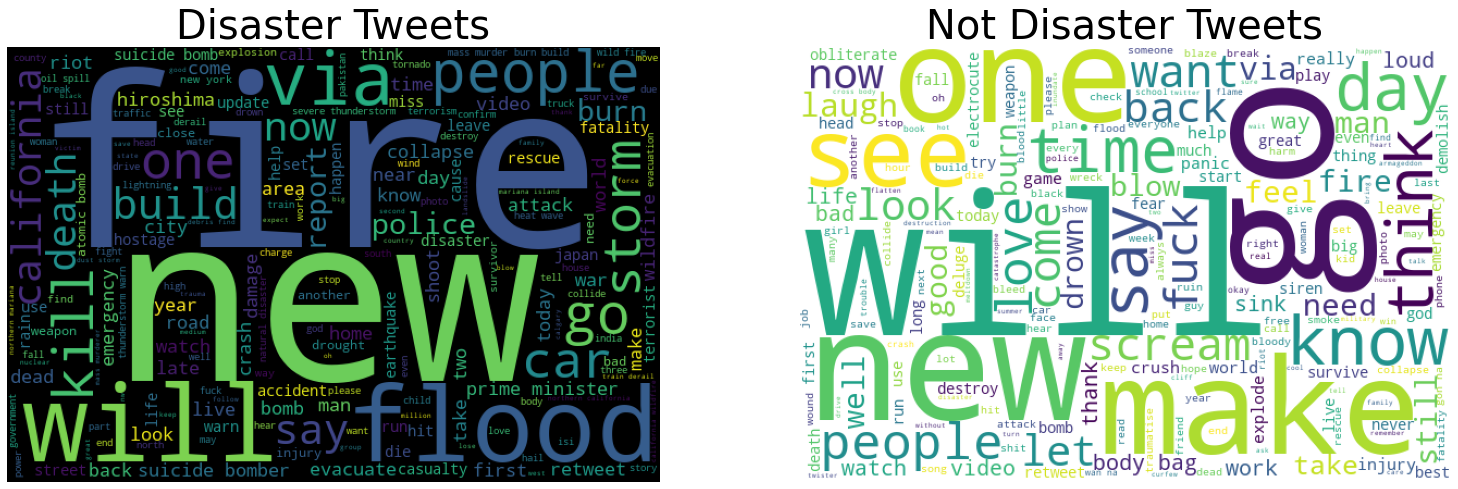

In [108]:
plot_wordcloud(train_df)

## extract bigrams

In [109]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from nltk.corpus import stopwords

In [110]:
len(tweets)

10114

In [169]:
def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(tweets)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=6, connector_words=ENGLISH_CONNECTOR_WORDS)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)


In [170]:
train_df['bigrams'], test_df['bigrams'] = bigrams[:len(train_df)], bigrams[len(train_df):] 

## prep text for vectorization

In [114]:
import re

import nltk
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopword_list and len(word) > 1:
                tokens.append(word.lower())
    return tokens

train_tweets = train_df.stems.astype(str).apply(tokenize_text)
test_tweets = test_df.stems.apply(tokenize_text)

In [172]:
train_df['texts'] = train_df.tweets.apply(tokenize_text)
test_df['texts'] = test_df.tweets.apply(tokenize_text)
train_df['bg'] = train_df.bigrams.apply(tokenize_text)
test_df['bg'] = test_df.bigrams.apply(tokenize_text)
#bigram_tokes = new_df.bigrams.apply(tokenize_text)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(train_df.bg, train_df.target, test_size=0.2, random_state=42)

In [174]:
word_dict = Counter(X_train.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
print(f'There are {vocab_size} unique words in the training dataset')
print("max len of training tweets",max([len(x) for x in X_train]))
print("max len of test tweets",max([len(x) for x in X_test]))
print("min len of training tweets",min([len(x) for x in X_train]))
print("min len of test tweets",min([len(x) for x in X_test]))
print("mean len of training tweets", mean([len(x) for x in X_train]))
print("mean len of test tweets",mean([len(x) for x in X_test]))

There are 72889 words in the training dataset
There are 12799 unique words in the training dataset
max len of training tweets 30
max len of test tweets 27
min len of training tweets 1
min len of test tweets 1
mean len of training tweets 13.300912408759125
mean len of test tweets 13.221006564551422


In [175]:
def get_embedding(word, model, vector_size):
    if word in model.wv:
        return model[x]
    else: 
        return np.zeros(vector_size)

def get_average_vector(model, list_of_tweets):    
    vec_dicts = {}
    for tweet in list_of_tweets:
        average_vector = (np.mean(np.array([get_embedding(tweet, model)]), axis=0))
        v_dict = {tweet : (average_vector)}
        vec_dicts.update(v_dict)
        return vec_dicts

In [176]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction   
import plotly

In [177]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly



## uninitialized skipgram

In [178]:
cores = multiprocessing.cpu_count()

In [179]:
# uninitializeed model
model_ui_sg = Word2Vec(
        vector_size=50,
        sg=1,
        negative=10,
        sample=1e-3,
        min_count=2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_ui_sg.build_vocab(X_train)

model_ui_sg.train(X_train, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=5)

(266517, 364445)

In [180]:
model_ui_sg.wv.most_similar(positive="wildfire")

[('near', 0.9967278838157654),
 ('county', 0.9965260028839111),
 ('northern_california', 0.9964895248413086),
 ('full_read', 0.9961672425270081),
 ('cross_body', 0.996120810508728),
 ('costlier_bigger', 0.9960567355155945),
 ('india', 0.9958125352859497),
 ('street', 0.9955621361732483),
 ('northern_mariana', 0.9955027103424072),
 ('prime_minister', 0.9954419732093811)]

In [181]:
model_ui_sg.wv.most_similar(positive="earthquake")

[('reported', 0.9970067739486694),
 ('attack', 0.9968788623809814),
 ('near', 0.9967849254608154),
 ('latest', 0.9966119527816772),
 ('live_to_recount', 0.9965243935585022),
 ('kills', 0.9964951872825623),
 ('county', 0.9964852333068848),
 ('usgs', 0.9964354634284973),
 ('northern_mariana', 0.9963988661766052),
 ('india', 0.9963617920875549)]

In [182]:
model_ui_sg.get_latest_training_loss()

476586.3125

In [183]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_sg)
plot_function(x_vals, y_vals, labels)

## self initialized skipgram

In [184]:
# uninitializeed model
model_si_sg = Word2Vec(
        sentences=X_train,
        vector_size=100,
        sg=0,
        min_count=2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_si_sg.build_vocab(X_train)

model_si_sg.train(X_train, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=5)

(266714, 364445)

In [185]:
model_si_sg.wv.most_similar(positive="earthquake")

[('will', 0.9997627139091492),
 ('after', 0.9997080564498901),
 ('her', 0.9997008442878723),
 ('new', 0.9996928572654724),
 ('or', 0.9996892809867859),
 ('into', 0.9996891021728516),
 ('storm', 0.9996770024299622),
 ('__url_here', 0.9996762275695801),
 ('some', 0.9996761083602905),
 ('people', 0.9996758103370667)]

In [186]:
model_si_sg.wv.most_similar(positive="fire")

[('on', 0.9997832775115967),
 ('turkish', 0.9997825026512146),
 ('armageddon', 0.9997790455818176),
 ('car', 0.999775230884552),
 ('good', 0.9997722506523132),
 ('at', 0.9997618198394775),
 ('new', 0.9997611045837402),
 ('us', 0.9997599720954895),
 ('inc', 0.9997584819793701),
 ('sarcasm', 0.9997537136077881)]

In [187]:
model_si_sg.get_latest_training_loss()

113208.734375

In [188]:
x_vals, y_vals, labels = reduce_dimensions(model_si_sg)
plot_function(x_vals, y_vals, labels)

# cbow

In [189]:
# uninitializeed model
model_ui_bow = Word2Vec(
        vector_size=100, 
        min_count=2,
        negative=6,
        sample=1e-3,
        window=4, 
        workers=cores)

vocab = model_ui_bow.build_vocab(X_train)

model_ui_bow.train(X_train, total_examples=model_ui_bow.corpus_count, epochs=10)

(533434, 728890)

In [190]:
model_ui_bow.wv.most_similar(positive="wildfire")

[('rescue', 0.9996278882026672),
 ('india', 0.999608039855957),
 ('flood', 0.9996048212051392),
 ('california', 0.9995899796485901),
 ('county', 0.9995899796485901),
 ('two', 0.9995781183242798),
 ('times', 0.9995754361152649),
 ('says', 0.9995622038841248),
 ('bag', 0.9995598196983337),
 ('retweet', 0.9995552897453308)]

In [191]:
model_ui_bow.wv.most_similar(positive="earthquake")

[('county', 0.9996484518051147),
 ('nuclear', 0.9996441006660461),
 ('street', 0.9996320605278015),
 ('emergency', 0.9996270537376404),
 ('accident', 0.9996044039726257),
 ('near', 0.9996001124382019),
 ('times', 0.9995917677879333),
 ('during', 0.9995880126953125),
 ('attack', 0.9995825886726379),
 ('killed', 0.9995817542076111)]

In [192]:
model_ui_bow.get_latest_training_loss()

0.0

In [193]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_bow)
plot_function(x_vals, y_vals, labels)

In [194]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_ui_bow.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['fire']  # Get numpy vector of a word
vector

array([-0.36541808,  0.37477306,  0.00433727,  0.17727534,  0.09249203,
       -1.2536288 ,  0.45263922,  1.1255949 , -0.5121107 , -0.44622222,
       -0.08460937, -0.9432749 ,  0.13483034,  0.44815174,  0.21867436,
       -0.4112403 ,  0.40844968, -0.5738068 , -0.00896528, -1.1451219 ,
        0.3879669 ,  0.1448771 ,  0.5924484 , -0.01918105, -0.13775021,
       -0.10194375, -0.48491815, -0.28957403, -0.6071805 ,  0.20762521,
        0.9326647 , -0.26404458,  0.15256736, -0.68934023, -0.18018879,
        0.5857238 ,  0.21051632, -0.3510654 , -0.47572467, -0.82030815,
        0.28084177, -0.74097776, -0.46499825,  0.00646586,  0.39973348,
       -0.06599838, -0.48152626, -0.07819653,  0.29168487,  0.31696233,
        0.26660243, -0.41995248, -0.10863881, -0.10117969, -0.2928769 ,
        0.16506587,  0.372679  , -0.11016709, -0.59967434,  0.10439267,
        0.09310298,  0.09749138, -0.00188314,  0.05444554, -0.36991572,
        0.5501875 ,  0.11978539,  0.38238326, -0.9324898 ,  0.68

In [195]:
# self initialized model
model_si_bow = Word2Vec(
        X_train,
        vector_size=100, 
        cbow_mean=1,
        min_count=2,
        window=2, 
        workers=cores)
vocab = model_si_bow.build_vocab(X_train)

model_si_bow.train(X_train,  total_examples=len(X_train), total_words=num_words, epochs=10)

(533355, 728890)

In [196]:
model_si_bow.wv.most_similar(positive="wildfire")

[('street', 0.9994968771934509),
 ('fires', 0.9994850754737854),
 ('times', 0.999439537525177),
 ('south', 0.9994298815727234),
 ('retweet', 0.9993693828582764),
 ('homes', 0.9993669986724854),
 ('flooding', 0.9993610978126526),
 ('red', 0.9993499517440796),
 ('military', 0.9993320107460022),
 ('deaths', 0.9993197917938232)]

In [197]:
model_si_bow.wv.most_similar(positive="earthquake")

[('hazard', 0.9995259642601013),
 ('county', 0.9995066523551941),
 ('black', 0.9994542598724365),
 ('rescued', 0.9994412064552307),
 ('wind', 0.9994202256202698),
 ('weapons', 0.9994109272956848),
 ('action', 0.9994094967842102),
 ('group', 0.9994032979011536),
 ('fatalities', 0.9994032382965088),
 ('against', 0.9994018077850342)]

In [221]:
x_vals, y_vals, labels = reduce_dimensions(model_si_bow)
plot_function(x_vals, y_vals, labels)

In [222]:
def get_embedding(word, model, vector_size):
    if word in model.wv:
        return model[x]
    else: 
        return np.zeros(vector_size)

def get_average_vector(model, list_of_tweets):    
    vec_dicts = {}
    for tweet in list_of_tweets:
        average_vector = (np.mean(np.array([get_embedding(tweet, model)]), axis=0))
        v_dict = {tweet : (average_vector)}
        vec_dicts.update(v_dict)
        return vec_dicts
    


## pretrained word_vectors model

In [419]:
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,SimpleRNN, AveragePooling1D, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [266]:
X_train, X_test, y_train, y_test = train_test_split(train_df.texts, train_df.target, test_size=0.1, random_state=42)

In [223]:
X_train = train_df.texts
y_train = train_df.target

In [267]:
from collections import Counter
from statistics import mean

word_dict = Counter(X_train.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
print(f'There are {vocab_size} unique words in the training dataset')
print("max len of training tweets",max([len(x) for x in X_train]))
print("max len of test tweets",max([len(x) for x in X_test]))
print("min len of training tweets",min([len(x) for x in X_train]))
print("min len of test tweets",min([len(x) for x in X_test]))
print("mean len of training tweets", mean([len(x) for x in X_train]))
print("mean len of test tweets",mean([len(x) for x in X_test]))

There are 70722 words in the training dataset
There are 10322 unique words in the training dataset
max len of training tweets 28
max len of test tweets 25
min len of training tweets 1
min len of test tweets 1
mean len of training tweets 11.471532846715329
mean len of test tweets 11.638483965014577


# embedding size : 50

In [550]:
# load the word embedding file from local
embeddings_index = dict()
f = open('utils//glove.6B.50d.txt', encoding="utf8")
# iterate through text, splitting, obtain index & float32 for words
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
# close embedding file from local to save on memory
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [551]:
maxlen = 30
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [552]:
tokenized_unseen_test = tokenizer.texts_to_sequences(test_df.texts)
unseen_test = sequence.pad_sequences(tokenized_unseen_test, maxlen=maxlen)

In [553]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
n_words = num_words
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std,(n_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### callbacks

In [555]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 2, verbose=1,factor=0.1, min_lr=0.01)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)

In [556]:
batch_size = 128
epochs = 100
embed_size = 50

#### adam

In [557]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(n_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(128, return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(32, recurrent_dropout = 0.15 , dropout = 0.15))
#model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [558]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/100
49/49 [==============================] - 15s 316ms/step - loss: 0.5351 - accuracy: 0.7478 - val_loss: 0.5388 - val_accuracy: 0.7464
Epoch 2/100
49/49 [==============================] - 15s 313ms/step - loss: 0.4727 - accuracy: 0.7893 - val_loss: 0.5277 - val_accuracy: 0.7493
Epoch 3/100
49/49 [==============================] - 15s 314ms/step - loss: 0.4616 - accuracy: 0.7963 - val_loss: 0.4971 - val_accuracy: 0.7624
Epoch 4/100
49/49 [==============================] - 15s 312ms/step - loss: 0.4575 - accuracy: 0.7945 - val_loss: 0.4975 - val_accuracy: 0.7609
Epoch 5/100
49/49 [==============================] - 15s 311ms/step - loss: 0.4488 - accuracy: 0.7969 - val_loss: 0.4926 - val_accuracy: 0.7638
Epoch 6/100
49/49 [==============================] - 15s 311ms/step - loss: 0.4459 - accuracy: 0.8008 - val_loss: 0.4998 - val_accuracy: 0.7580
Epoch 7/100
49/49 [==============================] - 15s 309ms/step - loss: 0.4415 - accuracy: 0.8031 - val_loss: 0.4949 - val_accuracy:

49/49 [==============================] - 15s 300ms/step - loss: 0.1345 - accuracy: 0.9478 - val_loss: 0.8333 - val_accuracy: 0.7536
Epoch 58/100
49/49 [==============================] - 15s 299ms/step - loss: 0.1305 - accuracy: 0.9489 - val_loss: 0.8964 - val_accuracy: 0.7478
Epoch 59/100
49/49 [==============================] - 15s 299ms/step - loss: 0.1337 - accuracy: 0.9476 - val_loss: 0.9235 - val_accuracy: 0.7493
Epoch 60/100
49/49 [==============================] - 15s 297ms/step - loss: 0.1184 - accuracy: 0.9541 - val_loss: 0.8559 - val_accuracy: 0.7405
Epoch 61/100
49/49 [==============================] - 15s 300ms/step - loss: 0.1168 - accuracy: 0.9543 - val_loss: 0.9480 - val_accuracy: 0.7420
Epoch 62/100
49/49 [==============================] - 15s 300ms/step - loss: 0.1097 - accuracy: 0.9573 - val_loss: 0.9141 - val_accuracy: 0.7478
Epoch 63/100
49/49 [==============================] - 15s 299ms/step - loss: 0.1153 - accuracy: 0.9562 - val_loss: 0.9050 - val_accuracy: 0.747

In [559]:
ynew = model.predict_classes(unseen_test)
submission = pd.read_csv('test.csv', usecols=['id'])
submission['target'] = ynew
submission.to_csv('predictions.csv')

#### rmsprop

In [560]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(n_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(128 , return_sequences = True , recurrent_dropout = 0.2 , dropout = 0.5))
model.add(LSTM(64, recurrent_dropout = 0.1 , dropout = 0.15))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.6), loss='binary_crossentropy', metrics=['accuracy'])

In [561]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs)

Epoch 1/100
49/49 [==============================] - 18s 365ms/step - loss: 0.5593 - accuracy: 0.7213 - val_loss: 0.6035 - val_accuracy: 0.7055
Epoch 2/100
49/49 [==============================] - 17s 357ms/step - loss: 0.5000 - accuracy: 0.7742 - val_loss: 0.5086 - val_accuracy: 0.7449
Epoch 3/100
49/49 [==============================] - 18s 357ms/step - loss: 0.4926 - accuracy: 0.7740 - val_loss: 0.4983 - val_accuracy: 0.7522
Epoch 4/100
49/49 [==============================] - 18s 357ms/step - loss: 0.4750 - accuracy: 0.7843 - val_loss: 0.5058 - val_accuracy: 0.7653
Epoch 5/100
49/49 [==============================] - 18s 359ms/step - loss: 0.4682 - accuracy: 0.7888 - val_loss: 0.4972 - val_accuracy: 0.7638
Epoch 6/100
49/49 [==============================] - 18s 357ms/step - loss: 0.4675 - accuracy: 0.7885 - val_loss: 0.5339 - val_accuracy: 0.7551
Epoch 7/100
49/49 [==============================] - 18s 357ms/step - loss: 0.4584 - accuracy: 0.7937 - val_loss: 0.4906 - val_accuracy:

49/49 [==============================] - 17s 351ms/step - loss: 0.3151 - accuracy: 0.8613 - val_loss: 0.5760 - val_accuracy: 0.7609
Epoch 58/100
49/49 [==============================] - 17s 353ms/step - loss: 0.3105 - accuracy: 0.8686 - val_loss: 0.5605 - val_accuracy: 0.7697
Epoch 59/100
49/49 [==============================] - 17s 353ms/step - loss: 0.3061 - accuracy: 0.8676 - val_loss: 0.5414 - val_accuracy: 0.7697
Epoch 60/100
49/49 [==============================] - 17s 352ms/step - loss: 0.3074 - accuracy: 0.8681 - val_loss: 0.5755 - val_accuracy: 0.7755
Epoch 61/100
49/49 [==============================] - 17s 352ms/step - loss: 0.2957 - accuracy: 0.8758 - val_loss: 0.6617 - val_accuracy: 0.7609
Epoch 62/100
49/49 [==============================] - 17s 352ms/step - loss: 0.2937 - accuracy: 0.8733 - val_loss: 0.6407 - val_accuracy: 0.7784
Epoch 63/100
49/49 [==============================] - 17s 353ms/step - loss: 0.2938 - accuracy: 0.8785 - val_loss: 0.6099 - val_accuracy: 0.766

In [562]:
ynew = model.predict_classes(unseen_test)
submission = pd.read_csv('test.csv', usecols=['id'])
submission['target'] = ynew
submission.to_csv('predictions1.csv')

# embedding size : 100

#### load embeddings from local

In [563]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('utils//glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [564]:
# fit embeddings to data
maxlen = 30 #max tweet length
tokenizer = text.Tokenizer(num_words=vocab_size) # vocab size of training data
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [565]:
tokenized_unseen_test = tokenizer.texts_to_sequences(test_df.texts)
unseen_test = sequence.pad_sequences(tokenized_unseen_test, maxlen=maxlen)

In [566]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
n_words = num_words
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std,(n_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [585]:
batch_size = 256
epochs = 50
embed_size = 100

#### adam

In [593]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(n_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(128, return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3))
model.add(LSTM(64,recurrent_dropout = 0.2 , dropout = 0.2))
#model.add(Dense(25, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
#model.add(Dense(4, activation = 'relu'))
#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) 

In [594]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/50
25/25 [==============================] - 18s 729ms/step - loss: 0.6830 - accuracy: 0.6039 - val_loss: 0.5976 - val_accuracy: 0.7216
Epoch 2/50
25/25 [==============================] - 18s 708ms/step - loss: 0.5079 - accuracy: 0.7719 - val_loss: 0.6459 - val_accuracy: 0.7055
Epoch 3/50
25/25 [==============================] - 18s 705ms/step - loss: 0.4683 - accuracy: 0.7908 - val_loss: 0.5146 - val_accuracy: 0.7522
Epoch 4/50
25/25 [==============================] - 18s 704ms/step - loss: 0.4327 - accuracy: 0.8130 - val_loss: 0.4810 - val_accuracy: 0.7697
Epoch 5/50
25/25 [==============================] - 18s 706ms/step - loss: 0.4287 - accuracy: 0.8083 - val_loss: 0.5124 - val_accuracy: 0.7741
Epoch 6/50
25/25 [==============================] - 18s 707ms/step - loss: 0.4163 - accuracy: 0.8174 - val_loss: 0.8237 - val_accuracy: 0.6560
Epoch 7/50
25/25 [==============================] - 18s 711ms/step - loss: 0.4129 - accuracy: 0.8269 - val_loss: 0.4886 - val_accuracy: 0.7668

In [592]:
ynew = model.predict_classes(unseen_test)
submission = pd.read_csv('test.csv', usecols=['id'])
submission['target'] = ynew
submission.to_csv('predictions2.csv')

In [571]:
### rmsprop

In [572]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(n_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
#model.add(LSTM(256 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.5))
model.add(LSTM(81, return_sequences = True, recurrent_dropout = 0.3 , dropout = 0.3))
model.add(LSTM(32, recurrent_dropout = 0.15 , dropout = 0.15))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) 

In [573]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [early_stop])

Epoch 1/100
193/193 [==============================] - 13s 67ms/step - loss: 0.6101 - accuracy: 0.6777 - val_loss: 0.5636 - val_accuracy: 0.7376
Epoch 2/100
193/193 [==============================] - 13s 65ms/step - loss: 0.5260 - accuracy: 0.7646 - val_loss: 0.5358 - val_accuracy: 0.7420
Epoch 3/100
193/193 [==============================] - 12s 65ms/step - loss: 0.4957 - accuracy: 0.7789 - val_loss: 0.5090 - val_accuracy: 0.7522
Epoch 4/100
193/193 [==============================] - 13s 65ms/step - loss: 0.4815 - accuracy: 0.7864 - val_loss: 0.5004 - val_accuracy: 0.7624
Epoch 5/100
193/193 [==============================] - 13s 65ms/step - loss: 0.4733 - accuracy: 0.7836 - val_loss: 0.4895 - val_accuracy: 0.7697
Epoch 6/100
193/193 [==============================] - 12s 65ms/step - loss: 0.4714 - accuracy: 0.7867 - val_loss: 0.5370 - val_accuracy: 0.7449
Epoch 7/100
193/193 [==============================] - 12s 65ms/step - loss: 0.4647 - accuracy: 0.7938 - val_loss: 0.4954 - val_ac

In [574]:
ynew = model.predict_classes(unseen_test)
submission = pd.read_csv('test.csv', usecols=['id'])
submission['target'] = ynew
submission.to_csv('predictions3.csv')